code: https://github.com/ritts97/Unsupervised-Face-Clustering

## Setup

In [1]:
import sys
import os
import dlib
import glob
import time

import cv2
import os

import matplotlib.pyplot as plt

from face_classifier import FaceClassifier

import random
import torch
import numpy as np

import calc
import icio
import postproc

from person_db import Person
from person_db import Face
from person_db import PersonDB

print(dlib.DLIB_USE_CUDA)
print(cv2.__version__)

/opt/conda/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/conda/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/opt/conda/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/conda/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


True
4.5.5


In [2]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = False  # type: ignore

seed_everything(79)

In [3]:
import face_recognition

def check_use_gpu(TARGET_IMG_PATH):
    image = face_recognition.load_image_file(TARGET_IMG_PATH)
    face_locations = face_recognition.face_locations(image,model='cnn')
    if len(face_locations) > 0:
        print('Using GPU')
    else:
        print('***Not using GPU***')

TARGET_IMG_PATH = "/opt/ml/project/test_videos/dongmin_before_15m_result_images_face_cloth/20220526_063429.551-0.png"
check_use_gpu(TARGET_IMG_PATH)

Using GPU


## Extract frame from video and save as images

In [4]:
video_paths = {
    0: "/opt/ml/project/test_videos/leejung_rain_before_14m.mp4",
    1: "/opt/ml/project/test_videos/giha_before_13m.mp4",
    2: "/opt/ml/project/test_videos/dongmin_before_15m.mp4",
    3: "/opt/ml/project/test_videos/KakaoTalk_20220526_162306287.mp4",
    4: "/opt/ml/project/test_videos/KakaoTalk_20220526_162432101.mp4",
    5: "/opt/ml/project/test_videos/KakaoTalk_20220526_162549989.mp4",
}

In [5]:
file_num = 5

filepath = video_paths[file_num]
video = cv2.VideoCapture(filepath)

assert video.isOpened(), f"Could not Open : {filepath}"

In [6]:
# 불러온 비디오 파일의 정보 출력
length = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = video.get(cv2.CAP_PROP_FPS)

print("length :", length)
print("width :", width)
print("height :", height)
print("fps :", fps)

length : 24184
width : 1280
height : 720
fps : 24.0


In [7]:
# 변수 설정
frame_batch_size = 16
capture_interval = 3 * int(round(fps)) # n초 간격 프레임 캡쳐
stop = 300 # 0 초과의 정수 지정 시 n 초 까지만 영상 실행
skip = 0 # 초반 n 초 skip
face_cnt = 150 # 몇 장의 인물 사진을 사용할 지
capture_cnt = 60
threshold = 0.36 # 같은 인물로 판단할 threshold -> 낮을수록 같은 인물로 판단하지 않음
ratio = 1.0 # resizing ratio인데, 건드리지 않는게 좋을 듯
running = True

In [8]:
result_dir = filepath[:-4] + '_result_images_face_cloth_pytorch_resnet18'
# pdb = PersonDB()
# pdb.load_db(result_dir)
# pdb.print_persons()

In [9]:
try:
    if not os.path.exists(result_dir):
        os.makedirs(result_dir)
except OSError:
    print('Error: Creaing directory. ' + result_dir)

**dnn_superres 사용**
```
pip uninstall opencv-python
pip uninstall opencv-contrib-python
pip3 install opencv-contrib-python
```
- 코드 및 성능비교표: https://learnopencv.com/super-resolution-in-opencv/ 
- super resolution 모델들 & 다운로드 링크: https://github.com/opencv/opencv_contrib/blob/master/modules/dnn_superres/README.md

In [10]:
video = cv2.VideoCapture(filepath) 

# FaceClssifier 인스턴스 생성
fc = FaceClassifier(threshold, ratio, result_dir)

fingerprints = dict()

frames = []
frame_count = 0
cnt = 0

start = time.time()
while running:
    ret, frame = video.read()

    if frame is None:
        break

    seconds = int(round(frame_count / fps, 3))
    # print(f"Running in {seconds} sec in video...")
    if seconds > stop > 0:
        break
    if seconds < skip:
        continue
    if frame_count % capture_interval == 0:
        frames.append(frame)

    if len(frames) == frame_batch_size:
        # 얼굴 디텍션 -> 얼굴 인코딩(frame, face_boxes) -> 옷 디텍션 -> 옷 인코딩(read_frames 코드 + _frame_worker 코드 + get_model 코드 + fingerprint 코드) -> 이미지 저장
        # 반환: 상체 이미지(파일명): [얼굴 인코딩 | 옷 인코딩] (fingerprint)
        frame_fingerprints = fc.detect_faces(frames,frame_batch_size)
        if frame_fingerprints:
            fingerprints.update(frame_fingerprints)
            print('Face images: ', len(fingerprints))
            cnt += 1
            print('frame_cnt: ', cnt)
            print()
        
        frames = []
        
    if cnt >= capture_cnt:
        break
    
    frame_count += 1



# restore SIGINT (^C) handler
running = False
video.release()
print()

# pdb.save_db(result_dir)
# pdb.print_persons()

end = time.time()
print('Inference time: ',end-start)
print("Captured frames : ", frame_count)

In [11]:
# video = cv2.VideoCapture(filepath) 

# # FaceClssifier 인스턴스 생성
# fc = FaceClassifier(threshold, ratio, result_dir)

# fingerprints = dict()

# frames = []
# frame_id = 0
# cnt = 0

# total_start_time = time.time()

# while running:
#     ret, frame = video.read()
    
#     if frame is None:
#         break

#     frame_id += 1
#     if frame_id % capture_interval != 0:
#         continue

#     seconds = int(round(frame_id / fps, 3))
#     print(f"Running in {seconds} sec in video...")
#     if seconds > stop > 0:
#         break
#     if seconds < skip:
#         continue

#     frames.append(frame)
#     # if frame_id % capture_interval == 0:
#     #     frames.append(frame)

#     if len(frames) == frame_batch_size:
#         # 얼굴 디텍션 -> 얼굴 인코딩(frame, face_boxes) -> 옷 디텍션 -> 옷 인코딩(read_frames 코드 + _frame_worker 코드 + get_model 코드 + fingerprint 코드) -> 이미지 저장
#         # 반환: 상체 이미지(파일명): [얼굴 인코딩 | 옷 인코딩] (fingerprint)
#         frame_fingerprints = fc.detect_faces(frames, frame_batch_size)

#         print('frame_fingerprints', frame_fingerprints)

#         if frame_fingerprints:
#             fingerprints.update(frame_fingerprints)
#             print('Face images: ', len(fingerprints))
#             print('frame_cnt: ', frame_id)
#             print()
            
#         frames = []

#     if len(fingerprints) >= face_cnt:
#         break



# # restore SIGINT (^C) handler
# running = False
# video.release()
# total_elapsed_time = time.time() - total_start_time

# print()
# print("Inference time : %.3f second" % total_elapsed_time)
# print('Captured frame : ', frame_id)

# # pdb.save_db(result_dir)
# # pdb.print_persons()

Running in 3 sec in video...
Running in 6 sec in video...
Running in 9 sec in video...
Running in 12 sec in video...
Running in 15 sec in video...
Running in 18 sec in video...
Running in 21 sec in video...
Running in 24 sec in video...
Running in 27 sec in video...
Running in 30 sec in video...
Running in 33 sec in video...
Running in 36 sec in video...
Running in 39 sec in video...
Running in 42 sec in video...
Running in 45 sec in video...
Running in 48 sec in video...
image saved path:  /opt/ml/project/test_videos/KakaoTalk_20220526_162549989_result_images_face_cloth_pytorch_resnet18/20220529_101239.522-0.png
image saved path:  /opt/ml/project/test_videos/KakaoTalk_20220526_162549989_result_images_face_cloth_pytorch_resnet18/20220529_101239.522-1.png
image saved path:  /opt/ml/project/test_videos/KakaoTalk_20220526_162549989_result_images_face_cloth_pytorch_resnet18/20220529_101239.522-2.png
image saved path:  /opt/ml/project/test_videos/KakaoTalk_20220526_162549989_result_images_f

In [12]:
filepath = video_paths[file_num]
result_dir = filepath[:-4] + '_result_images_face_cloth_pytorch_resnet18'

In [13]:
print(fingerprints)

{'/opt/ml/project/test_videos/KakaoTalk_20220526_162549989_result_images_face_cloth_pytorch_resnet18/20220529_101239.522-0.png': array([-0.04834334,  0.04592022,  0.06336591, -0.02001806, -0.09829123,
       -0.00076274,  0.00376462, -0.10039691,  0.1147835 , -0.09645589,
        0.11852139, -0.05577959, -0.18571011,  0.02955208, -0.01499158,
        0.12045754, -0.09666629, -0.05979556, -0.06189465, -0.05890425,
        0.03447314,  0.0887144 , -0.02426097,  0.06066723, -0.07375297,
       -0.19258875, -0.07948869, -0.00798513,  0.00531495, -0.04960718,
       -0.02711069,  0.05664639, -0.101408  ,  0.02452184,  0.02126256,
        0.05146413, -0.04450403, -0.06206993,  0.12725426,  0.01847358,
       -0.17511184,  0.05882994,  0.07542359,  0.13669863,  0.18398062,
       -0.033361  , -0.0412016 , -0.06667339,  0.10028061, -0.18592797,
        0.00311644,  0.14927195,  0.07130739,  0.06314722,  0.0350012 ,
       -0.11822741, -0.04960921,  0.08781903, -0.10539907,  0.01510114,
       

#images : #clusters
3 : 3
5 : 1
7 : 1
8 : 2
32 : 1
#images in clusters total:  69
cluster dir: /opt/ml/project/test_videos/KakaoTalk_20220526_162549989_result_images_face_cloth_pytorch_resnet18/imagecluster/clusters
/opt/ml/project/test_videos/KakaoTalk_20220526_162549989_result_images_face_cloth_pytorch_resnet18/20220529_101251.371-0.png/opt/ml/project/test_videos/KakaoTalk_20220526_162549989_result_images_face_cloth_pytorch_resnet18/20220529_100933.375-1.png/opt/ml/project/test_videos/KakaoTalk_20220526_162549989_result_images_face_cloth_pytorch_resnet18/20220529_100950.282-0.png/opt/ml/project/test_videos/KakaoTalk_20220526_162549989_result_images_face_cloth_pytorch_resnet18/20220529_100943.045-0.png/opt/ml/project/test_videos/KakaoTalk_20220526_162549989_result_images_face_cloth_pytorch_resnet18/20220529_101247.058-1.png/opt/ml/project/test_videos/KakaoTalk_20220526_162549989_result_images_face_cloth_pytorch_resnet18/20220529_100945.064-0.png/opt/ml/project/test_videos/KakaoTalk_20

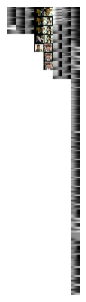

In [14]:
# 클러스터링(fingerprints) 후 결과 출력
clusters = calc.cluster(fingerprints, sim=0.65, method='single', min_csize=3) # 높일수록 엄격하게

postproc.make_links(clusters, os.path.join(result_dir, 'imagecluster/clusters'))

images = icio.read_images(result_dir, size=(224,224))

fig, ax = postproc.plot_clusters(clusters, images)
fig.savefig(os.path.join(result_dir, 'imagecluster/_cluster.png'))
postproc.plt.show()